## CBS data cleanup for each CITY in the NL

### Import libraries

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd

### CBS 2021 *** For PAPER 
- this was used because we have migration category 3 categories

Source: https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-100-meter-bij-100-meter-met-statistieken

### Dataoverlay Amsterdam and Setting the full squares  (set  border of a city)

No Weesp



#### This is used to gt the full squares ***Paper

### Chose the relevant columns CBS - Filter only what we need

### Checking the None values and preparing the dataset CBS 
- replace -99997 with None
### For PAPER* Check percentages of missing values

### SINGLE FUNCTIONS

In [10]:
def clip_and_filter_cbs_by_city(cbs: gpd.GeoDataFrame, city: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    cbs = cbs.to_crs(epsg=28992)
    city = city.to_crs(epsg=28992)
    clipped = gpd.overlay(cbs, city, how='intersection')
    unique_vals = clipped['crs28992res100m'].unique()
    filtered = cbs[cbs['crs28992res100m'].isin(unique_vals)].copy()

    return filtered[[
        'crs28992res100m',
        'aantal_inwoners',
        'aantal_inwoners_0_tot_15_jaar',
        'aantal_inwoners_15_tot_25_jaar',
        'aantal_inwoners_25_tot_45_jaar',
        'aantal_inwoners_45_tot_65_jaar',
        'aantal_inwoners_65_jaar_en_ouder',
        'percentage_nederlandse_achtergrond',
        'percentage_westerse_migr_achtergr',
        'percentage_niet_westerse_migr_achtergr',
        'aantal_woningen',
        'gemiddelde_woz_waarde_woning',
        'geometry'
    ]]


In [19]:
def clean_cbs_nan(gdf: gpd.GeoDataFrame) -> tuple[pd.DataFrame, gpd.GeoDataFrame]:
    nan_counts = (gdf == -99997).sum()
    nan_percentages = nan_counts / len(gdf) * 100
    nan_summary = pd.DataFrame({
        'NaN Count': nan_counts,
        'NaN Percentage (%)': nan_percentages
    })

    gdf.replace(-99997, np.nan, inplace=True)
    cleaned = gdf.dropna(subset=['aantal_inwoners']).copy()

    return nan_summary, cleaned


### Rename colums, recalculate absolute values, geometry set and EXPORT

In [20]:
def rename_and_recalculate(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf.columns = [
        'crs28992', 'A_inhab', 'A_0_15', 'A_15_25', 'A_25_45',
        'A_45_65', 'A_65+', 'P_nederlan', 'P_west_mig', 'P_n_west_mig',
        'A_woning', 'G_woz_woning', 'geometry'
    ]

    gdf['A_nederlan'] = gdf['P_nederlan'] / 100 * gdf['A_inhab']
    gdf['A_west_mig'] = gdf['P_west_mig'] / 100 * gdf['A_inhab']
    gdf['A_n_west_mig'] = gdf['P_n_west_mig'] / 100 * gdf['A_inhab']

    gdf.drop(columns=[c for c in gdf.columns if c.startswith('P_')], inplace=True)
    cols = [c for c in gdf.columns if c != 'geometry'] + ['geometry']
    return gdf[cols].copy()


## Final Function | CBS

### RAW DATA INPUT: CBS 100x100 NL / CITY BORDER
### DATA OUTPUT: CBS READY GDF FOR CITY 

In [36]:
def process_cbs_data(cbs: gpd.GeoDataFrame, city: gpd.GeoDataFrame) -> tuple[gpd.GeoDataFrame, pd.DataFrame]:
    """
    1. clip_and_filter_cbs_by_city: clip CBS data to city boundary and select relevant columns  
    2. clean_cbs_nan: replace -99997 with NaN and drop rows with NaN in 'aantal_inwoners'  
    3. rename_and_recalculate: rename columns and recalculate A_nederlan, A_west_mig, A_n_west_mig  

    Returns:
    - Cleaned CBS GeoDataFrame
    - NaN summary DataFrame
    """
    filtered = clip_and_filter_cbs_by_city(cbs, city)
    nan_summary, cleaned = clean_cbs_nan(filtered)
    semi_cbs = rename_and_recalculate(cleaned)
    return semi_cbs, nan_summary


In [32]:
# # USAGE
# cbs = gpd.read_file("data/2024-cbs_vk100_2021_vol/cbs_vk100_2021_vol.gpkg")
# city = gpd.read_file('Gemeente2.geojson')

semi_cbs, nan_summary = process_cbs_data_in_memory(cbs, city)


<Axes: >

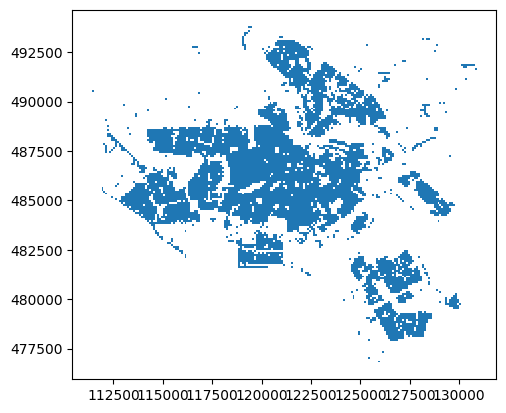

In [29]:
semi_cbs.plot()

In [37]:
nan_summary

,NaN Count,NaN Percentage (%)
crs28992res100m,0,0.000000
aantal_inwoners,64,0.918221
aantal_inwoners_0_tot_15_jaar,1597,22.912482
aantal_inwoners_15_tot_25_jaar,1848,26.513630
aantal_inwoners_25_tot_45_jaar,873,12.525108
aantal_inwoners_45_tot_65_jaar,842,12.080344
aantal_inwoners_65_jaar_en_ouder,1801,25.839311
percentage_nederlandse_achtergrond,489,7.015782
percentage_westerse_migr_achtergr,1379,19.784792
percentage_niet_westerse_migr_achtergr,1229,17.632712
